In [6]:
!pip install --upgrade pip pyqubo -q
!pip install --upgrade pip seaborn -q

In [1]:
# general imports
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import pickle
import random
from pyqubo import Array, Constraint, Placeholder

# magic line for producing visualizations in notebook
%matplotlib inline

In [2]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(a=seed)

# switch to trigger writing training results to disk
store_results = False
# switch to trigger printing results of each optimization cycle
verbose = False

In [3]:
# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Observable
from braket.aws import AwsSession, AwsDevice
from braket.devices import LocalSimulator

In [4]:
# Set up device: Local Simulator
device = LocalSimulator()

# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-buket-us-west-2" # the name of the bucket
my_prefix = "output" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [5]:
#problem setup
name="a3d2t2"
r_adt = [[[1,1],[0,1]],
         [[0,1],[1,1]],
         [[0,1],[1,1]]]

S_dt =  [[1,1],[1,1]]

G_ga = [[0,1,1]]

R_a = [2,2,2]

N_day = len(r_adt[0])
print("day : {}" .format(N_day))

N_emp = len(r_adt)
print("従業員数 : {}" .format(N_emp))

N_term = len(r_adt[0][0])
print("ターム数 : {}" .format(N_term))

print(r_adt)

N_group = len(G_ga)
print("グループの数 : {}".format(N_group))

print(G_ga)

print(f"希望割り当てシフト数 : {R_a}")

N_ver = N_day * N_emp * N_term
print(f"変数の総数 : {N_ver}")

#hyperparameter setup
w_desire = 20
w_group = 20

feed_dict = {'w_desire' : w_desire,
             'w_group' : w_group}

#QUBO式を作っていく
x = Array.create('x', shape=(N_emp,N_day,N_term), vartype='BINARY')

#目的関数、制約関数の設定

def build_objective_assign(x):
    H = sum((sum(
                x[a][d][t]
                for a in range(N_emp))
                    - S_dt[d][t]) ** 2
                    for d in range(N_day)
                    for t in range(N_term))
    return H

def build_objective_fair(x):
    H = sum((sum(x[a][d][t]
                for d in range(N_day)
                for t in range(N_term))
                    - R_a[a]) ** 2
                    for a in range(N_emp))
    return H

def build_desire(x):
    H = Constraint(
        sum((1 - r_adt[a][d][t]) *
            x[a][d][t]
            for a in range(N_emp)
            for d in range(N_day)
            for t in range(N_term)),
        'w_desire')
    return H

def build_group(x):
    H = Constraint(
        sum(((sum(G_ga[g][a]
                for a in range(N_emp))-
                sum(x[a][d][t]*G_ga[g][a]
                    for a in range(N_emp)))*
                    sum(x[a][d][t]*G_ga[g][a]
                        for a in range(N_emp)))
                            for g in range(N_group)
                            for d in range(N_day)
                            for t in range(N_term)),
            'w_group')
    return H

#関数を引き出す
H_objective_assign = build_objective_assign(x)
H_objective_fair = build_objective_fair(x)
H_desire = build_desire(x)
H_group = build_group(x)

Q = H_objective_assign + H_objective_fair + Placeholder('w_desire') * H_desire + Placeholder('w_group') * H_group

#辞書型に変換
model = Q.compile()
linear, quadratic, offset= model.to_ising(feed_dict=feed_dict)

print(linear)
print(quadratic)
print(offset)

day : 2
従業員数 : 3
ターム数 : 2
[[[1, 1], [0, 1]], [[0, 1], [1, 1]], [[0, 1], [1, 1]]]
グループの数 : 1
[[0, 1, 1]]
希望割り当てシフト数 : [2, 2, 2]
変数の総数 : 12
{'x[0][0][1]': 0.5, 'x[1][0][0]': 10.5, 'x[2][1][1]': 0.5, 'x[2][1][0]': 0.5, 'x[2][0][1]': 0.5, 'x[1][1][0]': 0.5, 'x[0][1][0]': 10.5, 'x[1][1][1]': 0.5, 'x[1][0][1]': 0.5, 'x[2][0][0]': 10.5, 'x[0][1][1]': 0.5, 'x[0][0][0]': 0.5}
{('x[0][1][1]', 'x[0][0][1]'): 0.5, ('x[2][1][0]', 'x[2][0][1]'): 0.5, ('x[1][1][1]', 'x[1][1][0]'): 0.5, ('x[2][1][1]', 'x[2][0][0]'): 0.5, ('x[0][1][1]', 'x[0][0][0]'): 0.5, ('x[2][0][0]', 'x[2][0][1]'): 0.5, ('x[1][0][1]', 'x[0][0][1]'): 0.5, ('x[2][1][1]', 'x[2][0][1]'): 0.5, ('x[2][1][0]', 'x[2][0][0]'): 0.5, ('x[0][0][0]', 'x[0][0][1]'): 0.5, ('x[0][1][0]', 'x[0][0][1]'): 0.5, ('x[1][1][0]', 'x[1][0][1]'): 0.5, ('x[0][1][0]', 'x[0][1][1]'): 0.5, ('x[2][0][1]', 'x[1][0][1]'): -9.5, ('x[1][0][0]', 'x[1][0][1]'): 0.5, ('x[1][1][1]', 'x[0][1][1]'): 0.5, ('x[1][1][0]', 'x[1][0][0]'): 0.5, ('x[2][1][1]', 'x[0][1][1]'): 0.5

[[ 0.5  0.   0.5  0.5  0.5  0.   0.   0.   0.5  0.   0.   0. ]
 [ 0.5  0.5  0.5  0.5  0.   0.5  0.   0.   0.   0.5  0.   0. ]
 [ 0.   0.  10.5  0.   0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.5  0.5  0.   0.   0.   0.5  0.   0.   0.   0.5]
 [ 0.   0.   0.   0.  10.5  0.   0.5  0.5 -9.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.5  0.5  0.5  0.5  0.  -9.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.5  0.5  0.   0.  -9.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.  -9.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  10.5  0.   0.5  0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.5  0.5  0.5  0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5  0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5]]


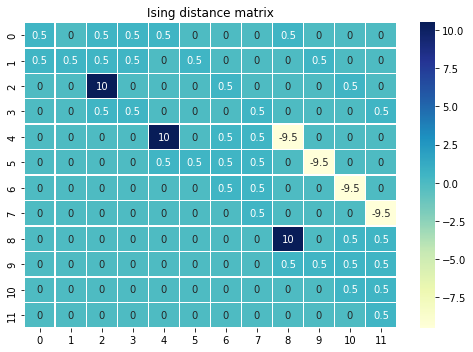

In [6]:
#create Jmatrix
J = np.zeros((N_ver,N_ver))

#change coordinate and add Jmatrix
for coordinate,value in linear.items():
    a = int(coordinate[2])
    d = int(coordinate[5])
    t = int(coordinate[8])
    ver = a*N_day*N_term + d*N_term + t
    J[ver][ver] = value

for coordinate,value in quadratic.items():
    a1 = int(coordinate[0][2])
    d1 = int(coordinate[0][5])
    t1 = int(coordinate[0][8])
    ver1 = a1*N_day*N_term + d1*N_term + t1
    a2 = int(coordinate[1][2])
    d2 = int(coordinate[1][5])
    t2 = int(coordinate[1][8])
    ver2 = a2*N_day*N_term + d2*N_term + t2
    J[ver2][ver1] = value

print(J)
"""
for i in range(len(J)):
    for j in range(i+1,len(J)):
        if J[j][i]!=0:
            J[i][j] = J[j][i]
            J[j][i] = 0
"""

# plot Ising matrix
plt.figure(1, figsize=[7, 5])
sns.heatmap(J, annot=True,  linewidths=.5, cmap="YlGnBu", annot_kws = {'alpha': 1})
plt.title('Ising distance matrix');
plt.tight_layout();
plt.savefig('Jmatrix_shift.png')

In [7]:
def build_classical_ising(J, N):
    """
    function to build classical Ising Hamiltonian
    """

    # define classical spin (Ising) variables
    spins = []
    for ii in range(N):
        spin_name = "s" + str(ii)
        spin = Spin(spin_name)
        spins.append(spin)

    # build Ising Hamiltonian
    ham = 0
    for ii in range(N):
        for jj in range(ii + 1, N):
            ham += J[ii][jj] * spins[ii] * spins[jj]

    # create Ising model
    model = ham.compile()
    linear, quad, offset = model.to_ising()

    return model, linear, quad, offset


def get_classical_energy_min(J, solution):
    """
    function to return min energy for given classical solution of
    Ising Hamiltonian with two-body terms for weigthed graph
    NO SINGLE BIT TERMS, NO CONSTANT OFFSET
    """

    N = J.shape[0]
    # calculate energy and maxcut (UNWEIGHTED graph)
    energy_min = 0
    for ii in range(N):
        for jj in range(ii + 1, N):
            energy_min += J[ii][jj] * solution["s" + str(ii)] * solution["s" + str(jj)]

    print("Minimal energy found classically:", energy_min)

    return energy_min

# function to implement ZZ gate using CNOT gates
def ZZgate(q1, q2, gamma):
    """
    function that returns a circuit implementing exp(-i \gamma Z_i Z_j) using CNOT gates if ZZ not supported
    """

    # get a circuit
    circ_zz = Circuit()

    # construct decomposition of ZZ
    circ_zz.cnot(q1, q2).rz(q2, gamma).cnot(q1, q2)

    return circ_zz


# function to implement evolution with driver Hamiltonian
def driver(beta, n_qubits):
    """
    Returns circuit for driver Hamiltonian U(Hb, beta)
    """
    # instantiate circuit object
    circ = Circuit()

    # apply parametrized rotation around x to every qubit
    for qubit in range(n_qubits):
        gate = Circuit().rx(qubit, 2 * beta)
        circ.add(gate)

    return circ


# helper function for evolution with cost Hamiltonian
def cost_circuit(gamma, n_qubits, ising, device):
    """
    returns circuit for evolution with cost Hamiltonian
    """
    # instantiate circuit object
    circ = Circuit()

    # get all non-zero entries (edges) from Ising matrix
    idx = ising.nonzero()
    edges = list(zip(idx[0], idx[1]))

    # apply ZZ gate for every edge (with corresponding interaction strength)
    for qubit_pair in edges:
        if (qubit_pair[0] != qubit_pair[1]):
            # get interaction strength from Ising matrix
            int_strength = ising[qubit_pair[0], qubit_pair[1]]
            # for Rigetti we decompose ZZ using CNOT gates
            if device.name == "Rigetti":
                gate = ZZgate(qubit_pair[0], qubit_pair[1], gamma * int_strength)
                circ.add(gate)
            # classical simulators and IonQ support ZZ gate
            else:
                gate = Circuit().zz(qubit_pair[0], qubit_pair[1], angle=2 * gamma * int_strength)
                circ.add(gate)
        else:
            gate = Circuit().rz(qubit_pair[0], 2 * gamma)
            circ.add(gate)

    return circ


# function to build the QAOA circuit with depth p
def circuit(params, device, n_qubits, ising):
    """
    function to return full QAOA circuit; depends on device as ZZ implementation depends on gate set of backend
    """

    # initialize qaoa circuit with first Hadamard layer: for minimization start in |->
    circ = Circuit()
    X_on_all = Circuit().x(range(0, n_qubits))
    circ.add(X_on_all)
    H_on_all = Circuit().h(range(0, n_qubits))
    circ.add(H_on_all)

    # setup two parameter families
    circuit_length = int(len(params) / 2)
    gammas = params[:circuit_length]
    betas = params[circuit_length:]

    # add QAOA circuit layer blocks
    for mm in range(circuit_length):
        circ.add(cost_circuit(gammas[mm], n_qubits, ising, device))
        circ.add(driver(betas[mm], n_qubits))

    return circ


# function that computes cost function for given params
def objective_function(params, device, ising, n_qubits, n_shots, tracker, s3_folder, verbose):
    """
    objective function takes a list of variational parameters as input,
    and returns the cost associated with those parameters
    """

    if verbose:
        print("==================================" * 2)
        print("Calling the quantum circuit. Cycle:", tracker["count"])

    # get a quantum circuit instance from the parameters
    qaoa_circuit = circuit(params, device, n_qubits, ising)

    # classically simulate the circuit
    # execute the correct device.run call depending on whether the backend is local or cloud based
    if isinstance(device, LocalSimulator):
        task = device.run(qaoa_circuit, shots=n_shots)
    else:
        task = device.run(
            qaoa_circuit, s3_folder, shots=n_shots, poll_timeout_seconds=3 * 24 * 60 * 60
        )

    # get result for this task
    result = task.result()

    # get metadata
    metadata = result.task_metadata

    # convert results (0 and 1) to ising (-1 and 1)
    meas_ising = result.measurements
    meas_ising[meas_ising == 0] = -1

    # get all energies (for every shot): (n_shots, 1) vector
    all_energies = np.diag(np.dot(meas_ising, np.dot(ising, np.transpose(meas_ising))))

    # find minimum and corresponding classical string
    energy_min = np.min(all_energies)
    tracker["opt_energies"].append(energy_min)
    optimal_string = meas_ising[np.argmin(all_energies)]
    tracker["opt_bitstrings"].append(optimal_string)

    # store optimal (classical) result/bitstring
    if energy_min < tracker["optimal_energy"]:
        tracker.update({"optimal_energy": energy_min})
        tracker.update({"optimal_bitstring": optimal_string})

    # store global minimum
    tracker["global_energies"].append(tracker["optimal_energy"])

    # energy expectation value
    energy_expect = np.sum(all_energies) / n_shots

    if verbose:
        print("Minimal energy:", energy_min)
        print("Optimal classical string:", optimal_string)
        print("Energy expectation value (cost):", energy_expect)

    # update tracker
    tracker.update({"count": tracker["count"] + 1, "res": result})
    tracker["costs"].append(energy_expect)
    tracker["params"].append(params)

    return energy_expect


# The function to execute the training: run classical minimization.
def train(
    device, options, p, ising, n_qubits, n_shots, opt_method, tracker, s3_folder, verbose=True
):
    """
    function to run QAOA algorithm for given, fixed circuit depth p
    """
    print("Starting the training.")

    print("==================================" * 2)
    print(f"OPTIMIZATION for circuit depth p={p}")

    if not verbose:
        print('Param "verbose" set to False. Will not print intermediate steps.')
        print("==================================" * 2)

    # initialize
    cost_energy = []

    # randomly initialize variational parameters within appropriate bounds
    gamma_initial = np.random.uniform(0, 2 * np.pi, p).tolist()
    beta_initial = np.random.uniform(0, np.pi, p).tolist()
    params0 = np.array(gamma_initial + beta_initial)

    # set bounds for search space
    bnds_gamma = [(0, 2 * np.pi) for _ in range(int(len(params0) / 2))]
    bnds_beta = [(0, np.pi) for _ in range(int(len(params0) / 2))]
    bnds = bnds_gamma + bnds_beta

    tracker["params"].append(params0)

    # run classical optimization (example: method='Nelder-Mead')
    result = minimize(
        objective_function,
        params0,
        args=(device, ising, n_qubits, n_shots, tracker, s3_folder, verbose),
        options=options,
        method=opt_method,
        bounds=bnds,
    )

    # store result of classical optimization
    result_energy = result.fun
    cost_energy.append(result_energy)
    print("Final average energy (cost):", result_energy)
    result_angle = result.x
    print("Final angles:", result_angle)
    print("Training complete.")

    return result_energy, result_angle, tracker

In [8]:
##################################################################################
# set up hyperparameters
##################################################################################

# User-defined hypers
DEPTH = 3  # circuit depth for QAOA
SHOTS = 10  # number measurements to make on circuit
OPT_METHOD = 'Powell'  # SLSQP, COBYLA, Nelder-Mead, BFGS, Powell, ...

# set up the problem
n_qubits = J.shape[0]

# initialize reference solution (simple guess)
bitstring_init = -1 * np.ones([n_qubits])
energy_init = np.dot(bitstring_init, np.dot(J, bitstring_init))

# set tracker to keep track of results
tracker = {
    'count': 1,                           # Elapsed optimization steps
    'optimal_energy': energy_init,        # Global optimal energy
    'opt_energies': [],                   # Optimal energy at each step
    'global_energies': [],                # Global optimal energy at each step
    'optimal_bitstring': bitstring_init,  # Global optimal bitstring
    'opt_bitstrings': [],                 # Optimal bitstring at each step
    'costs': [],                          # Cost (average energy) at each step
    'res': None,                          # Quantum result object
    'params': []                          # Track parameters
}

# set options for classical optimization
options = {'disp': True, 'maxiter': 500}
# options = {'disp': True, 'ftol': 1e-08, 'maxiter': 100, 'maxfev': 50}  # example options
print(n_qubits)

12


In [9]:
##################################################################################
# run QAOA optimization on graph 
##################################################################################

print('Circuit depth hyperparameter:', DEPTH)
print('Problem size:', n_qubits)

# kick off training
start = time.time()
result_energy, result_angle, tracker = train(
    device = device, options=options, p=DEPTH, ising=J, n_qubits=n_qubits, n_shots=SHOTS, 
    opt_method=OPT_METHOD, tracker=tracker, s3_folder=s3_folder, verbose=verbose)
end = time.time()

# print execution time
print('Code execution time [sec]:', end - start)
print('minimum cost:',min(tracker['costs']))

# print optimized results
print('Optimal energy:', tracker['optimal_energy'])
print('Optimal classical bitstring:', tracker['optimal_bitstring'])

##################################################################################
# Compute output and dump to pickle
##################################################################################

if store_results:
    out = {'p': DEPTH, 'N': n_qubits,
           'ENERGY_OPTIMAL': tracker['optimal_energy'], 'BITSTRING': tracker['optimal_bitstring'],
           'result_energy': result_energy, 'result_angle': result_angle}

    # store results: dump output to pickle with timestamp in filename
    time_now = datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
    results_file = 'results-'+time_now+'.pkl'
    print(f'Writing results to file: {results_file}')
    pickle.dump(out, open(results_file, "wb"))
    
    # you can load results as follows
    # out = pickle.load(open(results_file, "rb"))

Circuit depth hyperparameter: 3
Problem size: 12
Starting the training.
OPTIMIZATION for circuit depth p=3
Param "verbose" set to False. Will not print intermediate steps.
Optimization terminated successfully.
         Current function value: 23.500000
         Iterations: 3
         Function evaluations: 378
Final average energy (cost): 23.5
Final angles: [0.91667102 4.76341005 4.22740722 1.24816801 1.09190769 2.35514088]
Training complete.
Code execution time [sec]: 17.563169717788696
minimum cost: 12.1
Optimal energy: -9.0
Optimal classical bitstring: [ 1  1 -1 -1 -1 -1  1  1 -1 -1  1  1]


In [12]:
# print the optimal energy found with QAOA 
print('Optimal energy found with QAOA:', tracker['optimal_energy'])
# print the corresponding bitstring
print('Optimal bit-string found with QAOA:', tracker['optimal_bitstring'])

Optimal energy found with QAOA: -9.0
Optimal bit-string found with QAOA: [ 1  1 -1 -1 -1 -1  1  1 -1 -1  1  1]


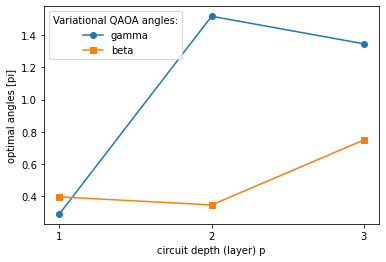

In [13]:
# get results for variational angles
gamma = result_angle[:DEPTH]
beta = result_angle[DEPTH:]
# get array [1, 2, ..., p]
pa = np.arange(1, DEPTH + 1)

plt.figure(2)
plt.plot(pa, gamma / np.pi, '-o', label='gamma')
plt.plot(pa, beta / np.pi, '-s', label='beta')
plt.xlabel('circuit depth (layer) p')
plt.ylabel('optimal angles [pi]')
plt.xticks(pa)
plt.legend(title='Variational QAOA angles:', loc='upper left')
plt.savefig('Variational_QAOA_angles_local.png')
plt.show()

In [14]:
#最適解をadtに戻す,z={1,-1}→z={1,0}に戻す
solution=tracker['optimal_bitstring']
print(solution)
solution[solution == -1] = 0
x_solution = {}
for a in range(N_emp):
    x_solution[a] = {}
    for d in range(N_day):
        x_solution[a][d] = {}
        for t in range(N_term):
            x_solution[a][d][t] = {}
            x_solution[a][d][t] = solution[a*N_day*N_term + d*N_term + t]
print(x_solution)

[ 1  1 -1 -1 -1 -1  1  1 -1 -1  1  1]
{0: {0: {0: 1, 1: 1}, 1: {0: 0, 1: 0}}, 1: {0: {0: 0, 1: 0}, 1: {0: 1, 1: 1}}, 2: {0: {0: 0, 1: 0}, 1: {0: 1, 1: 1}}}


In [15]:
#ペナルティ数を数える
def calculation_constraint_desire(x):
    H = 0
    for a in range(N_emp):
        for d in range(N_day):
            for t in range(N_term):
                H += (1 - r_adt[a][d][t])*x[a][d][t]
    return H

def calculation_constraint_group(x):
    H = 0
    for d in range(N_day):
        for t in range(N_term):
            for g in range(N_group):
                I,J = 0,0
                for a in range(N_emp):
                    I += G_ga[g][a]
                    J += x[a][d][t]*G_ga[g][a]
                H += (I - J)*J
    return H

print('violation w_desire:',calculation_constraint_desire(x_solution))
print('violation w_group:',calculation_constraint_group(x_solution))

violation w_desire: 0
violation w_group: 0


Optimization  optimized with Powell and 10 shots per call; seed=42.


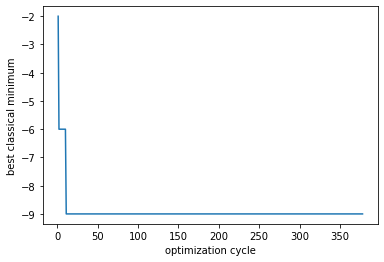

In [16]:
# visualize the optimization process
cycles = np.arange(1, tracker['count'])
optim_classical = tracker['global_energies']

# print information
info = 'Optimization  optimized with {} and {} shots per call; seed={}.'
print(info.format( OPT_METHOD, SHOTS, seed))

plt.plot(cycles, optim_classical)
plt.xlabel('optimization cycle')
plt.ylabel('best classical minimum')
plt.savefig('optimization_process_local.png')
plt.show()

In [77]:
qaoa_circuit = circuit(pa, device, n_qubits, J)
print(qaoa_circuit)

T   : |0|1|  2  |  3  |  4  |     5     |  6  |  7  |  8  |     9     |       10        |       11        | 12  | 13  | 14  |    15     |  16   | 17  | 18  | 19  |    20     |     21      |     22      |     23      | 24  | 25  | 26  | 27  |    28     | 29  | 30  | 31  |
                                                                                                                                                                                                                                                                               
q0  : -X-H-Rz(2)-ZZ(1)-ZZ(1)-ZZ(1)-------ZZ(1)-------------------------------------ZZ(1)-Rx(4)---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                 |     |     |           |                                         |                                                                                                    